## Contents
- Implement PCA for dimensionality reduction
- Before clustering we decide if we want to keep only males
- Do clustering

In [86]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

In [87]:
KEEP_ONLY_MALES = True

### Cluster biometrics

In [88]:
# read pickle file
imputed_df = pd.read_pickle('../data_processed/biometrics_m50_imputed.pkl')
mean_values = pd.read_pickle('../data_processed/biometrics_mean_per_week.pkl')

all_users = mean_values.copy()

imputed_df['gender_m']=mean_values['gender_m'].values
imputed_df['gender_f']=mean_values['gender_f'].values

# columns_to_keep = ['Age', 'BMI', 'Basal Metabolic Rate', 'Bone Mass', 'Degree Of Obesity Perc',
#                    'Extra Cellular Water Perc', 'Fat Free Mass', 'Fat mass Perc', 'Height', 
#                    'Intra Cellular Water', 'Left Arm Fat Perc', 'Left Leg Fat Perc', 'Metabolic Age', 
#                    'Muscle Mass', 'Muscle Mass Balance Arm', 'Muscle Mass Balance Leg', 
#                    'Right Arm Fat Perc', 'Right Leg Fat Perc', 'Standard Body Weight', 
#                    'Total Body Water Perc', 'Trunk Fat Perc', 'Trunk Muscle Mass', 
#                    'Visceral Fat Rating', 'Weight', 'gender_m', 'gender_f']

columns_to_keep = ['Age', 'BMI', 'Basal Metabolic Rate', 'Bone Mass', 'Degree Of Obesity Perc',
                   'Fat Free Mass', 'Fat mass Perc', 'Height', 'Intra Cellular Water', 
                   'Left Arm Fat Perc', 'Left Leg Fat Perc', 'Metabolic Age', 'Muscle Mass',
                   'Right Arm Fat Perc', 'Right Leg Fat Perc', 'Standard Body Weight', 
                   'Total Body Water Perc', 'Trunk Fat Perc', 'Trunk Muscle Mass', 
                   'Visceral Fat Rating', 'Weight', 'gender_m', 'gender_f']

imputed_df = imputed_df[columns_to_keep]
imputed_df.head()


Age   BMI  Basal Metabolic Rate  Bone Mass  Degree Of Obesity Perc  \
0 56.00 29.19               1938.70       3.62                   23.93   
1 56.00 29.19               1938.70       3.62                   23.93   
2 56.00 29.19               1938.70       3.62                   23.93   
3 56.00 28.59               1896.90       3.58                   24.62   
4 56.00 28.50               1905.90       3.56                   27.38   

   Fat Free Mass  Fat mass Perc  Height  Intra Cellular Water  \
0          67.98          22.88  174.00                 30.12   
1          67.98          22.88  174.00                 30.12   
2          67.98          22.88  174.00                 30.12   
3          66.16          22.93  173.50                 29.65   
4          67.00          21.89  172.90                 30.38   

   Left Arm Fat Perc  Left Leg Fat Perc  Metabolic Age  Muscle Mass  \
0              17.40              20.69          46.00        63.19   
1              17.40              20.69          46.00        63.19   
2              17.40              20.69          46.00        63.19   
3              17.15              20.48          44.70        61.90   
4              16.31              21.04          42.50        61.29   

   Right Arm Fat Perc  Right Leg Fat Perc  Standard Body Weight  \
0               16.60               20.70                 71.17   
1               16.60               20.70                 71.17   
2               16.60               20.70                 71.17   
3               15.97               20.73                 69.95   
4               15.83               21.14                 67.54   

   Total Body Water Perc  Trunk Fat Perc  Trunk Muscle Mass  \
0                  56.47           21.69              36.98   
1                  56.47           21.69              36.98   
2                  56.47           21.69              36.98   
3                  56.36           23.90              35.15   
4                  56.53           24.00              34.75   

   Visceral Fat Rating  Weight  gender_m  gender_f  
0                10.10   88.00      1.00      0.00  
1                10.10   88.00      1.00      0.00  
2                10.10   88.00      1.00      0.00  
3                10.40   87.00      1.00      0.00  
4                 9.90   86.00      1.00      0.00

## Normalize measurements to account for age and height

In [89]:
# Normalize measurements by height
height_measurements = ['Weight', 'Muscle Mass', 'Fat Free Mass', 'Bone Mass', 'Trunk Muscle Mass']
for col in height_measurements:
    imputed_df[f'{col}_per_height'] = imputed_df[col] / imputed_df['Height']

# Normalize measurements by age
age_measurements = ['Basal Metabolic Rate', 'Metabolic Age']
for col in age_measurements:
    imputed_df[f'{col}_per_age'] = imputed_df[col] / imputed_df['Age']

# Drop age and height from the dataset
imputed_df.drop(['Age', 'Height'], axis=1, inplace=True)

In [90]:
imputed_df.head()

BMI  Basal Metabolic Rate  Bone Mass  Degree Of Obesity Perc  \
0 29.19               1938.70       3.62                   23.93   
1 29.19               1938.70       3.62                   23.93   
2 29.19               1938.70       3.62                   23.93   
3 28.59               1896.90       3.58                   24.62   
4 28.50               1905.90       3.56                   27.38   

   Fat Free Mass  Fat mass Perc  Intra Cellular Water  Left Arm Fat Perc  \
0          67.98          22.88                 30.12              17.40   
1          67.98          22.88                 30.12              17.40   
2          67.98          22.88                 30.12              17.40   
3          66.16          22.93                 29.65              17.15   
4          67.00          21.89                 30.38              16.31   

   Left Leg Fat Perc  Metabolic Age  Muscle Mass  Right Arm Fat Perc  \
0              20.69          46.00        63.19               16.60   
1              20.69          46.00        63.19               16.60   
2              20.69          46.00        63.19               16.60   
3              20.48          44.70        61.90               15.97   
4              21.04          42.50        61.29               15.83   

   Right Leg Fat Perc  Standard Body Weight  Total Body Water Perc  \
0               20.70                 71.17                  56.47   
1               20.70                 71.17                  56.47   
2               20.70                 71.17                  56.47   
3               20.73                 69.95                  56.36   
4               21.14                 67.54                  56.53   

   Trunk Fat Perc  Trunk Muscle Mass  Visceral Fat Rating  Weight  gender_m  \
0           21.69              36.98                10.10   88.00      1.00   
1           21.69              36.98                10.10   88.00      1.00   
2           21.69              36.98                10.10   88.00      1.00   
3           23.90              35.15                10.40   87.00      1.00   
4           24.00              34.75                 9.90   86.00      1.00   

   gender_f  Weight_per_height  Muscle Mass_per_height  \
0      0.00               0.51                    0.36   
1      0.00               0.51                    0.36   
2      0.00               0.51                    0.36   
3      0.00               0.50                    0.36   
4      0.00               0.50                    0.35   

   Fat Free Mass_per_height  Bone Mass_per_height  \
0                      0.39                  0.02   
1                      0.39                  0.02   
2                      0.39                  0.02   
3                      0.38                  0.02   
4                      0.39                  0.02   

   Trunk Muscle Mass_per_height  Basal Metabolic Rate_per_age  \
0                          0.21                         34.62   
1                          0.21                         34.62   
2                          0.21                         34.62   
3                          0.20                         33.87   
4                          0.20                         34.03   

   Metabolic Age_per_age  
0                   0.82  
1                   0.82  
2                   0.82  
3                   0.80  
4                   0.76

### We keep a subset of the features to account for the age and height

In [91]:
# Define the list of features to include
features_to_include = [
    'BMI', 'Degree Of Obesity Perc', 'Fat mass Perc', 'Intra Cellular Water',
    'Left Arm Fat Perc', 'Left Leg Fat Perc', 'Right Arm Fat Perc', 'Right Leg Fat Perc',
    'Standard Body Weight', 'Total Body Water Perc', 'Trunk Fat Perc', 'Visceral Fat Rating',
    'gender_m', 'gender_f',
    'Weight_per_height', 'Muscle Mass_per_height', 'Fat Free Mass_per_height',
    'Bone Mass_per_height', 'Trunk Muscle Mass_per_height',
    'Basal Metabolic Rate_per_age', 'Metabolic Age_per_age'
]

# Select the features for clustering
clustering_data = imputed_df[features_to_include]

# Display the first few rows
clustering_data.head()

BMI  Degree Of Obesity Perc  Fat mass Perc  Intra Cellular Water  \
0 29.19                   23.93          22.88                 30.12   
1 29.19                   23.93          22.88                 30.12   
2 29.19                   23.93          22.88                 30.12   
3 28.59                   24.62          22.93                 29.65   
4 28.50                   27.38          21.89                 30.38   

   Left Arm Fat Perc  Left Leg Fat Perc  Right Arm Fat Perc  \
0              17.40              20.69               16.60   
1              17.40              20.69               16.60   
2              17.40              20.69               16.60   
3              17.15              20.48               15.97   
4              16.31              21.04               15.83   

   Right Leg Fat Perc  Standard Body Weight  Total Body Water Perc  \
0               20.70                 71.17                  56.47   
1               20.70                 71.17                  56.47   
2               20.70                 71.17                  56.47   
3               20.73                 69.95                  56.36   
4               21.14                 67.54                  56.53   

   Trunk Fat Perc  Visceral Fat Rating  gender_m  gender_f  Weight_per_height  \
0           21.69                10.10      1.00      0.00               0.51   
1           21.69                10.10      1.00      0.00               0.51   
2           21.69                10.10      1.00      0.00               0.51   
3           23.90                10.40      1.00      0.00               0.50   
4           24.00                 9.90      1.00      0.00               0.50   

   Muscle Mass_per_height  Fat Free Mass_per_height  Bone Mass_per_height  \
0                    0.36                      0.39                  0.02   
1                    0.36                      0.39                  0.02   
2                    0.36                      0.39                  0.02   
3                    0.36                      0.38                  0.02   
4                    0.35                      0.39                  0.02   

   Trunk Muscle Mass_per_height  Basal Metabolic Rate_per_age  \
0                          0.21                         34.62   
1                          0.21                         34.62   
2                          0.21                         34.62   
3                          0.20                         33.87   
4                          0.20                         34.03   

   Metabolic Age_per_age  
0                   0.82  
1                   0.82  
2                   0.82  
3                   0.80  
4                   0.76

## Keep only males

In [92]:
if (KEEP_ONLY_MALES):
    clustering_data = clustering_data[clustering_data['gender_m']==1]
bio = clustering_data.copy()

In [93]:
bio.head()

BMI  Degree Of Obesity Perc  Fat mass Perc  Intra Cellular Water  \
0 29.19                   23.93          22.88                 30.12   
1 29.19                   23.93          22.88                 30.12   
2 29.19                   23.93          22.88                 30.12   
3 28.59                   24.62          22.93                 29.65   
4 28.50                   27.38          21.89                 30.38   

   Left Arm Fat Perc  Left Leg Fat Perc  Right Arm Fat Perc  \
0              17.40              20.69               16.60   
1              17.40              20.69               16.60   
2              17.40              20.69               16.60   
3              17.15              20.48               15.97   
4              16.31              21.04               15.83   

   Right Leg Fat Perc  Standard Body Weight  Total Body Water Perc  \
0               20.70                 71.17                  56.47   
1               20.70                 71.17                  56.47   
2               20.70                 71.17                  56.47   
3               20.73                 69.95                  56.36   
4               21.14                 67.54                  56.53   

   Trunk Fat Perc  Visceral Fat Rating  gender_m  gender_f  Weight_per_height  \
0           21.69                10.10      1.00      0.00               0.51   
1           21.69                10.10      1.00      0.00               0.51   
2           21.69                10.10      1.00      0.00               0.51   
3           23.90                10.40      1.00      0.00               0.50   
4           24.00                 9.90      1.00      0.00               0.50   

   Muscle Mass_per_height  Fat Free Mass_per_height  Bone Mass_per_height  \
0                    0.36                      0.39                  0.02   
1                    0.36                      0.39                  0.02   
2                    0.36                      0.39                  0.02   
3                    0.36                      0.38                  0.02   
4                    0.35                      0.39                  0.02   

   Trunk Muscle Mass_per_height  Basal Metabolic Rate_per_age  \
0                          0.21                         34.62   
1                          0.21                         34.62   
2                          0.21                         34.62   
3                          0.20                         33.87   
4                          0.20                         34.03   

   Metabolic Age_per_age  
0                   0.82  
1                   0.82  
2                   0.82  
3                   0.80  
4                   0.76

#### PCA

In [94]:
bio_features = bio.drop(columns=['gender_f', 'gender_m'])

scaler = StandardScaler()
bio_scaled = scaler.fit_transform(bio_features)

num_clusters = 6  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(bio_scaled)

# Add cluster labels to the DataFrame
bio_clustered = bio.copy()
bio_clustered['Cluster'] = labels

# Optional: Visualize the clusters using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(bio_scaled)
pca_df_bio = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df_bio['Cluster'] = labels


fig = px.scatter(
    pca_df_bio, 
    x='PCA1', 
    y='PCA2', 
    color=labels, 
    title='PCA of Biometric Profiles',
)

fig.update_traces(marker=dict(size=1))

fig.show()

In [95]:
bio_clustered.drop(columns=['gender_f', 'gender_m'], inplace=True)

In [96]:
# Group by 'Cluster' and calculate the mean for each group, keeping only numerical features
numerical_features = [col for col in bio_clustered.columns if bio_clustered[col].dtype in ['int64', 'float64']]

cluster_means = bio_clustered.groupby('Cluster')[numerical_features].mean()

# Add the count of records in each cluster
cluster_counts = bio_clustered['Cluster'].value_counts().sort_index()
cluster_means['Count'] = cluster_counts

# Display the average column values for each cluster along with the count
cluster_means

BMI  Degree Of Obesity Perc  Fat mass Perc  Intra Cellular Water  \
Cluster                                                                      
0       24.97                   11.61          18.06                 29.78   
1       24.81                   11.96          14.22                 30.13   
2       28.93                   30.47          23.41                 30.61   
3       25.42                   14.41          22.46                 24.87   
4       22.06                    0.92          14.51                 23.23   
5       33.51                   51.95          31.97                 30.01   

         Left Arm Fat Perc  Left Leg Fat Perc  Right Arm Fat Perc  \
Cluster                                                             
0                    17.14              17.97               16.38   
1                    12.95              14.51               12.87   
2                    20.64              21.16               19.99   
3                    19.91              21.71               19.29   
4                    12.83              15.28               12.43   
5                    31.06              30.54               30.04   

         Right Leg Fat Perc  Standard Body Weight  Total Body Water Perc  \
Cluster                                                                    
0                     17.44                 69.69                  58.78   
1                     14.11                 71.58                  60.53   
2                     21.06                 72.57                  53.83   
3                     21.65                 66.14                  53.96   
4                     15.17                 64.59                  60.61   
5                     30.97                 67.87                  48.42   

         Trunk Fat Perc  Visceral Fat Rating  Weight_per_height  \
Cluster                                                           
0                 20.13                 6.15               0.45   
1                 14.85                 4.98               0.45   
2                 25.58                10.46               0.52   
3                 24.35                11.27               0.44   
4                 14.60                 7.02               0.38   
5                 34.34                16.06               0.60   

         Muscle Mass_per_height  Fat Free Mass_per_height  \
Cluster                                                     
0                          0.19                      0.37   
1                          0.35                      0.38   
2                          0.37                      0.40   
3                          0.32                      0.34   
4                          0.30                      0.32   
5                          0.33                      0.40   

         Bone Mass_per_height  Trunk Muscle Mass_per_height  \
Cluster                                                       
0                        0.03                          0.18   
1                        0.02                          0.20   
2                        0.02                          0.21   
3                        0.02                          0.18   
4                        0.02                          0.17   
5                        0.02                          0.20   

         Basal Metabolic Rate_per_age  Metabolic Age_per_age  Count  
Cluster                                                              
0                               43.76                   0.83   4989  
1                               58.25                   0.69  11691  
2                               50.66                   1.05   8988  
3                               30.23                   0.85  14605  
4                               34.28                   0.69   9958  
5                               46.89                   1.28   3674

In [97]:
bio_mean = bio_clustered[numerical_features].mean()
bio_std = bio_clustered[numerical_features].std()
cluster_means_scaled_df = (cluster_means - bio_mean) / bio_std

In [98]:
# Function to find the quantile for a given value
def find_quantile(value, feature_values):
    return np.count_nonzero(feature_values < value) / feature_values.size

# Find the quantile for each cluster mean
cluster_quantiles = pd.DataFrame(index=cluster_means.index, columns=cluster_means.columns)

for feature in cluster_means.columns:
    if feature == 'Count':
        continue
    feature_values = bio[feature].values
    for cluster in cluster_means.index:
        cluster_mean = cluster_means.at[cluster, feature]
        quantile = find_quantile(cluster_mean, feature_values)
        cluster_quantiles.at[cluster, feature] = quantile

In [99]:
# x% of the data points for that feature in the original dataset are less
# than the cluster mean.
cluster_quantiles

BMI Degree Of Obesity Perc Fat mass Perc Intra Cellular Water  \
Cluster                                                                  
0       0.47                   0.45          0.42                 0.72   
1       0.45                   0.46          0.20                 0.75   
2       0.83                   0.84          0.74                 0.79   
3       0.53                   0.55          0.69                 0.28   
4       0.12                   0.12          0.22                 0.16   
5       0.97                   0.96          0.96                 0.75   

        Left Arm Fat Perc Left Leg Fat Perc Right Arm Fat Perc  \
Cluster                                                          
0                    0.48              0.44               0.46   
1                    0.20              0.19               0.21   
2                    0.75              0.70               0.74   
3                    0.71              0.73               0.70   
4                    0.20              0.24               0.19   
5                    0.97              0.97               0.97   

        Right Leg Fat Perc Standard Body Weight Total Body Water Perc  \
Cluster                                                                 
0                     0.43                 0.57                  0.66   
1                     0.18                 0.73                  0.78   
2                     0.69                 0.77                  0.28   
3                     0.73                 0.35                  0.29   
4                     0.25                 0.24                  0.79   
5                     0.97                 0.47                  0.05   

        Trunk Fat Perc Visceral Fat Rating Weight_per_height  \
Cluster                                                        
0                 0.44                0.30              0.53   
1                 0.20                0.17              0.51   
2                 0.76                0.66              0.84   
3                 0.69                0.73              0.46   
4                 0.19                0.38              0.12   
5                 0.96                0.96              0.96   

        Muscle Mass_per_height Fat Free Mass_per_height Bone Mass_per_height  \
Cluster                                                                        
0                         0.07                     0.55                 0.94   
1                         0.67                     0.70                 0.60   
2                         0.79                     0.83                 0.72   
3                         0.39                     0.29                 0.29   
4                         0.29                     0.15                 0.19   
5                         0.52                     0.84                 0.86   

        Trunk Muscle Mass_per_height Basal Metabolic Rate_per_age  \
Cluster                                                             
0                               0.36                         0.61   
1                               0.68                         0.83   
2                               0.83                         0.74   
3                               0.38                         0.28   
4                               0.17                         0.40   
5                               0.73                         0.68   

        Metabolic Age_per_age Count  
Cluster                              
0                        0.63   NaN  
1                        0.26   NaN  
2                        0.81   NaN  
3                        0.65   NaN  
4                        0.26   NaN  
5                        0.92   NaN

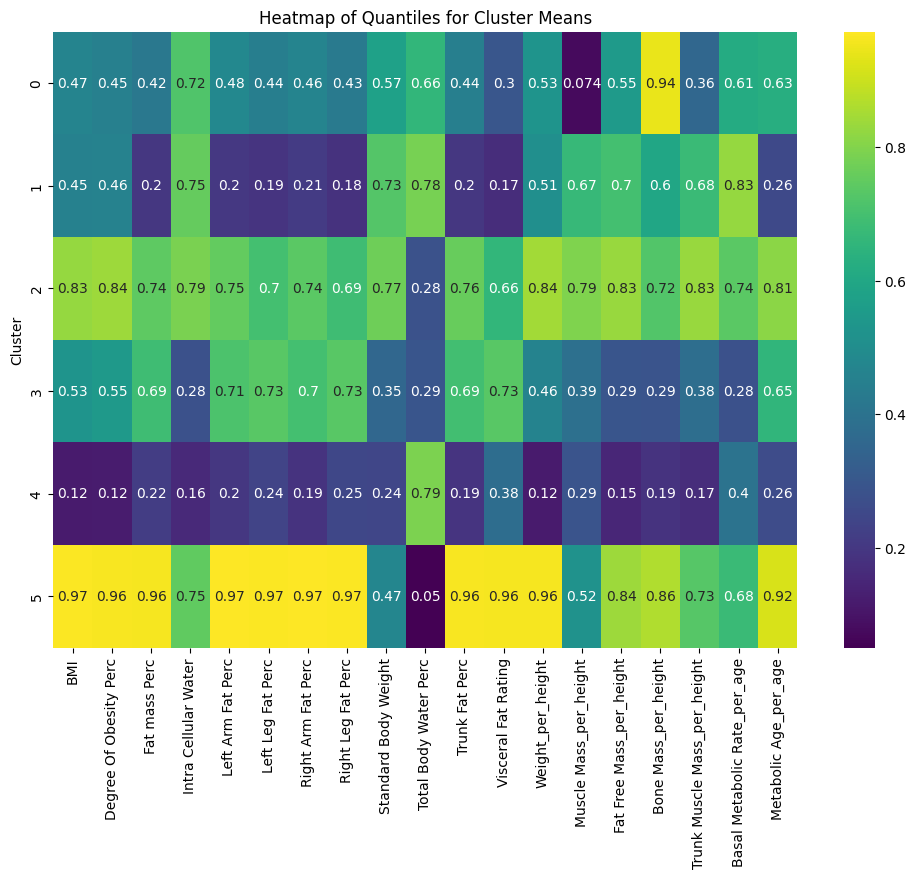

In [100]:
# Convert cluster_quantiles to numeric
cluster_quantiles_numeric = cluster_quantiles.apply(pd.to_numeric, errors='coerce')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_quantiles_numeric.drop(columns=['Count']), annot=True, cmap='viridis')
plt.title('Heatmap of Quantiles for Cluster Means')
plt.show()

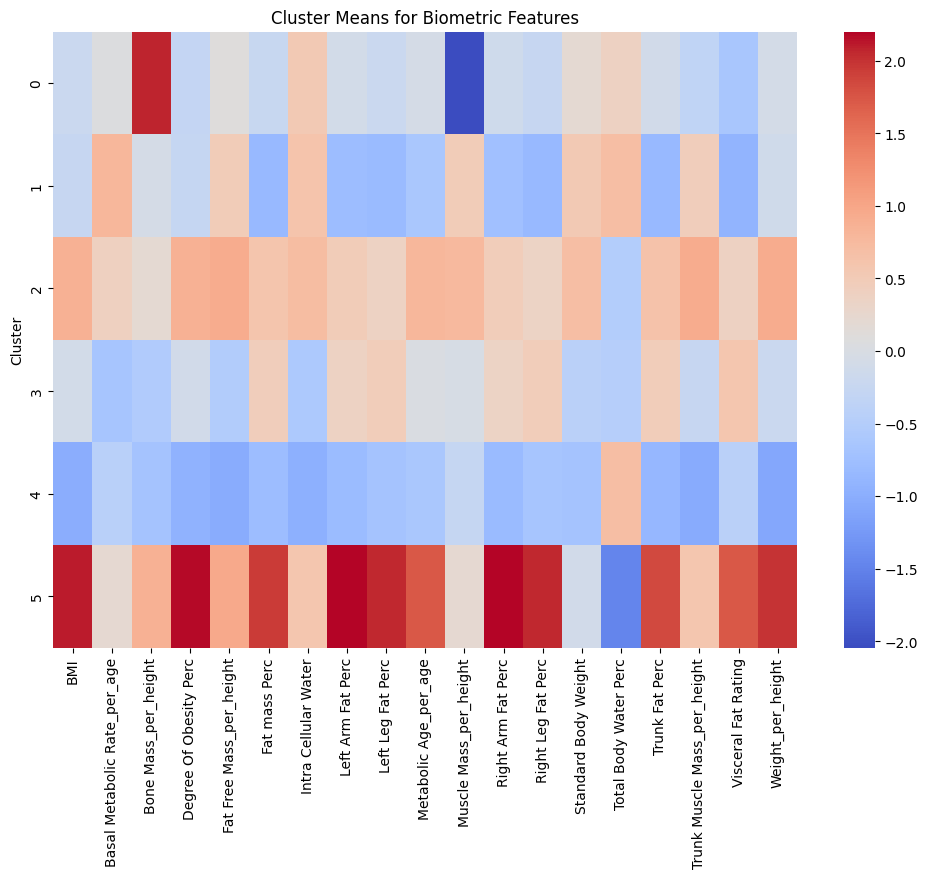

In [101]:
# plot cluster means for each feature without counts dont show counts
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means_scaled_df.drop(columns=['Count']), annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Cluster Means for Biometric Features')
plt.show()


In [102]:
bio_clustered['CloudId'] = mean_values[mean_values['gender_m']==1]['CloudId'].values
bio_clustered['MeasuredOnWeek'] = mean_values[mean_values['gender_m']==1]['MeasuredOnWeek'].values

In [103]:
# Group by CloudId and count the number of unique clusters for each user
user_cluster_counts = bio_clustered.groupby('CloudId')['Cluster'].nunique()

# Filter users who have more than one distinct cluster
users_with_multiple_clusters = user_cluster_counts[user_cluster_counts > 1]

# Get the number of such users
num_users_with_multiple_clusters = users_with_multiple_clusters.shape[0]

total_users = bio_clustered['CloudId'].nunique()
percentage_users_with_multiple_clusters = (num_users_with_multiple_clusters / total_users) * 100

percentage_users_with_multiple_clusters

40.27777777777778

Keep only those users and perform analysis only to them

In [104]:
bio_clustered['PCA1'] = pca_df_bio['PCA1'].values
bio_clustered['PCA2'] = pca_df_bio['PCA2'].values

In [105]:
# Filter the bio DataFrame to keep only those users with multiple clusters
bio_filtered = bio_clustered[bio_clustered['CloudId'].isin(users_with_multiple_clusters.index)]

# Display the shape of the filtered DataFrame
bio_filtered.shape

(22722, 24)

In [106]:
bio_filtered.to_pickle('../data_processed/biometrics_clustered_males.pkl')

In [ ]:
# store to file
# bio_filtered.to_pickle('../data_cleaned/biometrics_m10_imputed_clustered_changes.pkl')


---------------------------------

#### TSNE

In [ ]:


# Standardize the Data
scaler = StandardScaler()
bio_scaled = scaler.fit_transform(bio_features)

# Apply t-SNE for visualization
tsne = TSNE(n_components=2, perplexity=40, max_iter=2000, random_state=42)
tsne_result = tsne.fit_transform(bio_scaled)
tsne_df_bio = pd.DataFrame(tsne_result, columns=['TSNE1', 'TSNE2'])

In [ ]:
from sklearn.cluster import KMeans
# Apply Clustering
num_clusters = 4 # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
bio['Cluster'] = kmeans.fit_predict(bio_scaled)
tsne_df_bio['Cluster'] = bio['Cluster']

<Axes: xlabel='TSNE1', ylabel='TSNE2'>

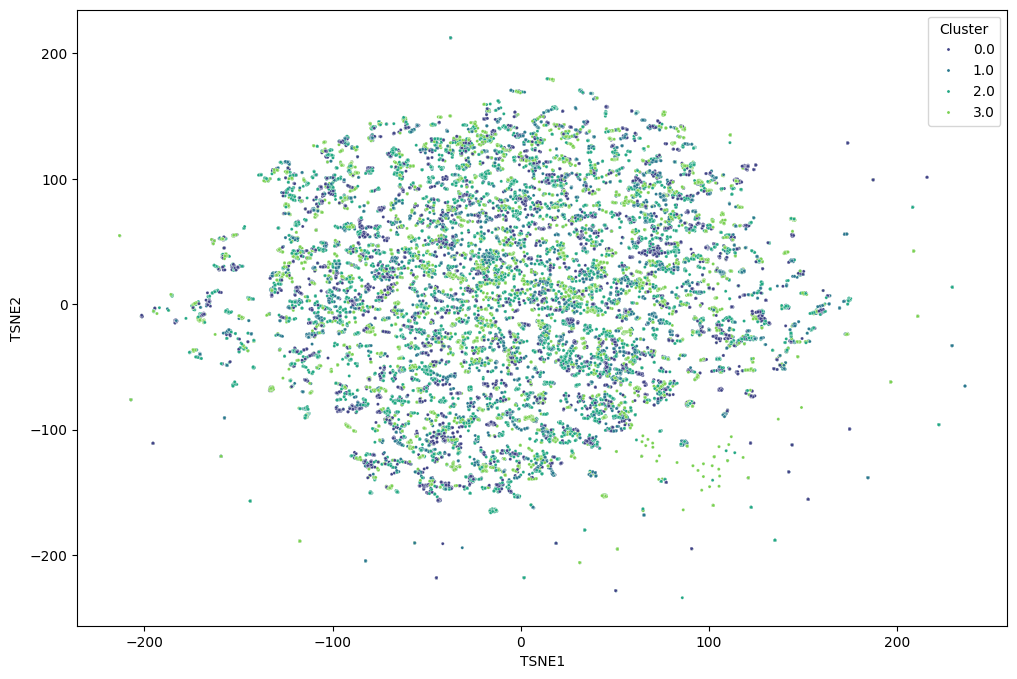

In [22]:
# Plot the data with Seaborn and Matplotlib
plt.figure(figsize=(12, 8))

# Define a color palette
palette = sns.color_palette("viridis", num_clusters)

# Plot the clusters
sns.scatterplot(
    x='TSNE1', 
    y='TSNE2', 
    hue='Cluster', 
    palette=palette, 
    data=tsne_df_bio, 
    legend='full', 
    s=5 # Marker size
)

### UMAP

/opt/anaconda3/envs/umap/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



<Axes: xlabel='UMAP1', ylabel='UMAP2'>

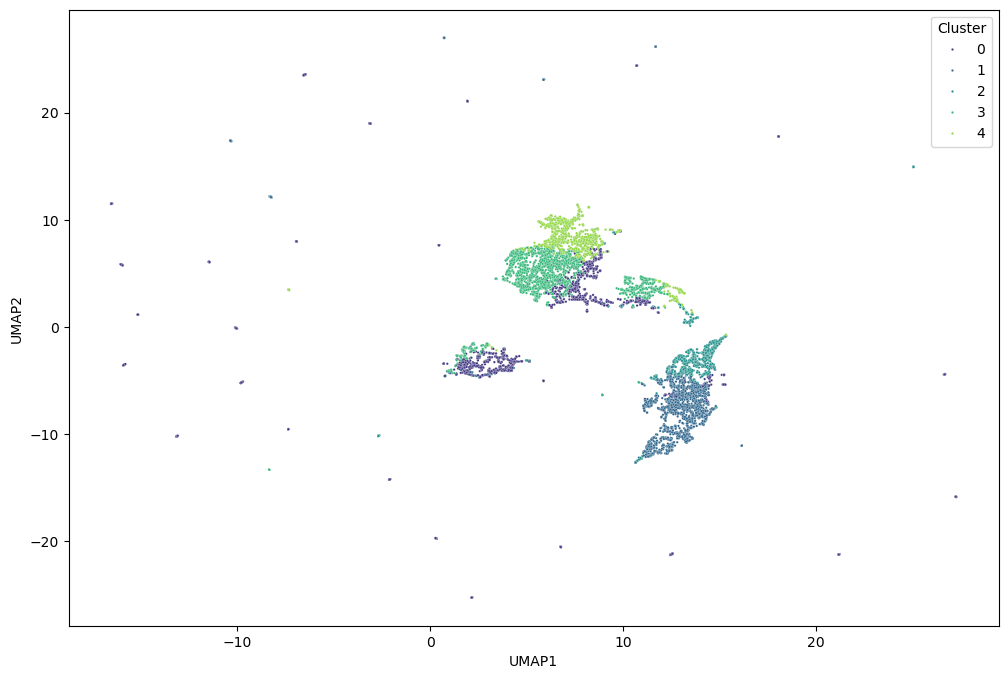

In [49]:
import umap

# Apply UMAP for visualization
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_reducer.fit_transform(bio_scaled)
umap_df_bio = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'])
umap_df_bio['Cluster'] = bio_sample['Cluster']
umap_df_bio['CloudId'] = bio_sample['CloudId']



In [ ]:
# Plot the data with Seaborn and Matplotlib
plt.figure(figsize=(12, 8))

# Define a color palette
palette = sns.color_palette("viridis", num_clusters)

# Plot the clusters
sns.scatterplot(
    x='UMAP1', 
    y='UMAP2', 
    hue='Cluster', 
    palette=palette, 
    data=umap_df_bio, 
    legend='full', 
    s=3  # Marker size
)

In [195]:
# merge bio and pca_df on cloudid and keep only the columns with PCA1 and PCA2
bio_pca = pd.merge(bio, pca_df, on=['CloudId', 'MeasuredOnWeek'])

In [55]:
# Select a subset of unique CloudId values (e.g., the first 30 unique CloudIds)
import plotly.graph_objects as go
unique_cloud_ids = pca_df_bio['CloudId'].unique()[:30]

# Initialize a new figure
fig = go.Figure()

# Iterate over each selected CloudId and add a trace for each
for cloud_id in unique_cloud_ids:
    user_data = pca_df_bio[pca_df_bio['CloudId'] == cloud_id]
    fig.add_trace(go.Scatter(
        x=user_data['PCA1'],
        y=user_data['PCA2'],
        mode='lines+markers',
        line_shape='spline',
        text=user_data.apply(lambda row: '<br>'.join([f'{col}: {row[col]}' for col in ['Cluster']]), axis=1),
        # text=user_data.apply(lambda row: '<br>'.join([f'{col}: {row[col]}' for col in ['Weight', 'Basal Metabolic Rate', 'Basal Metabolic Rate Score', 'Degree Of Obesity Perc', 'Cluster']]), axis=1),
        # hoverinfo='text',
        marker_color=user_data['Cluster'],  # Adjusted marker size and color by cluster
        line=dict(shape='spline'),
    ))

fig.update_layout(
    title='2D PCA Plot of User Data by Week with Temporal Evolution',
    xaxis_title='PCA1',
    yaxis_title='PCA2',
    showlegend=True
)

# Add a legend to the plot
fig.update_layout(
    legend_title_text='Cluster',
    legend_title_font_size=16,
    legend_font_size=12
)

fig.show()